In [13]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import Model

class ClassToken(Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value = w_init(shape=(1, 1, input_shape[-1]), dtype=tf.float32),
            trainable = True
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        hidden_dim = self.w.shape[-1]

        cls = tf.broadcast_to(self.w, [batch_size, 1, hidden_dim])
        cls = tf.cast(cls, dtype=inputs.dtype)
        return cls

def mlp(x, cf):
    x = Dense(cf["mlp_dim"], activation="gelu")(x)
    x = Dropout(cf["dropout_rate"])(x)
    x = Dense(cf["hidden_dim"])(x)
    x = Dropout(cf["dropout_rate"])(x)
    return x

def transformer_encoder(x, cf):
    skip_1 = x
    x = LayerNormalization()(x)
    x = MultiHeadAttention(
        num_heads=cf["num_heads"], key_dim=cf["hidden_dim"]
    )(x, x)
    x = Add()([x, skip_1])

    skip_2 = x
    x = LayerNormalization()(x)
    x = mlp(x, cf)
    x = Add()([x, skip_2])

    return x

def ViT(cf):
    """ Inputs """
    input_shape = (cf["num_patches"], cf["patch_size"]*cf["patch_size"]*cf["num_channels"])
    inputs = Input(input_shape)     ## (None, 256, 3072)

    """ Patch + Position Embeddings """
    patch_embed = Dense(cf["hidden_dim"])(inputs)   ## (None, 256, 768)

    positions = tf.range(start=0, limit=cf["num_patches"], delta=1)
    pos_embed = Embedding(input_dim=cf["num_patches"], output_dim=cf["hidden_dim"])(positions) ## (256, 768)
    embed = patch_embed + pos_embed ## (None, 256, 768)

    """ Adding Class Token """
    token = ClassToken()(embed)
    x = Concatenate(axis=1)([token, embed]) ## (None, 257, 768)

    for _ in range(cf["num_layers"]):
        x = transformer_encoder(x, cf)

    """ Classification Head """
    x = LayerNormalization()(x)     ## (None, 257, 768)
    x = x[:, 0, :]
    x = Dense(cf["num_classes"], activation="softmax")(x)

    model = Model(inputs, x)
    return model


if __name__ == "__main__":
    config = {}
    config["num_layers"] = 24
#     config["hidden_dim"] = 768
#     config["mlp_dim"] =3072
    config["num_heads"] = 12
    config["dropout_rate"] = 0.1
    config["num_patches"] = 256
    config["patch_size"] = 32
    config["num_channels"] = 3
    config["num_classes"] = 3

    config["hidden_dim"] = 256
    config["mlp_dim"] = 1024  

    model = ViT(config)
    model.summary()



Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 256, 3072)]          0         []                            
                                                                                                  
 dense_700 (Dense)           (None, 256, 256)             786688    ['input_15[0][0]']            
                                                                                                  
 tf.__operators__.add_19 (T  (None, 256, 256)             0         ['dense_700[0][0]']           
 FOpLambda)                                                                                       
                                                                                                  
 class_token_40 (ClassToken  (None, 1, 256)               256       ['tf.__operators__.add_

 layer_normalization_691 (L  (None, 257, 256)             512       ['add_676[0][0]']             
 ayerNormalization)                                                                               
                                                                                                  
 dense_705 (Dense)           (None, 257, 1024)            263168    ['layer_normalization_691[0][0
                                                                    ]']                           
                                                                                                  
 dropout_1300 (Dropout)      (None, 257, 1024)            0         ['dense_705[0][0]']           
                                                                                                  
 dense_706 (Dense)           (None, 257, 256)             262400    ['dropout_1300[0][0]']        
                                                                                                  
 dropout_1

                                                                                                  
 dense_711 (Dense)           (None, 257, 1024)            263168    ['layer_normalization_697[0][0
                                                                    ]']                           
                                                                                                  
 dropout_1306 (Dropout)      (None, 257, 1024)            0         ['dense_711[0][0]']           
                                                                                                  
 dense_712 (Dense)           (None, 257, 256)             262400    ['dropout_1306[0][0]']        
                                                                                                  
 dropout_1307 (Dropout)      (None, 257, 256)             0         ['dense_712[0][0]']           
                                                                                                  
 add_683 (

                                                                    ]']                           
                                                                                                  
 dropout_1312 (Dropout)      (None, 257, 1024)            0         ['dense_717[0][0]']           
                                                                                                  
 dense_718 (Dense)           (None, 257, 256)             262400    ['dropout_1312[0][0]']        
                                                                                                  
 dropout_1313 (Dropout)      (None, 257, 256)             0         ['dense_718[0][0]']           
                                                                                                  
 add_689 (Add)               (None, 257, 256)             0         ['dropout_1313[0][0]',        
                                                                     'add_688[0][0]']             
          

 dropout_1318 (Dropout)      (None, 257, 1024)            0         ['dense_723[0][0]']           
                                                                                                  
 dense_724 (Dense)           (None, 257, 256)             262400    ['dropout_1318[0][0]']        
                                                                                                  
 dropout_1319 (Dropout)      (None, 257, 256)             0         ['dense_724[0][0]']           
                                                                                                  
 add_695 (Add)               (None, 257, 256)             0         ['dropout_1319[0][0]',        
                                                                     'add_694[0][0]']             
                                                                                                  
 layer_normalization_710 (L  (None, 257, 256)             512       ['add_695[0][0]']             
 ayerNorma

 dense_730 (Dense)           (None, 257, 256)             262400    ['dropout_1324[0][0]']        
                                                                                                  
 dropout_1325 (Dropout)      (None, 257, 256)             0         ['dense_730[0][0]']           
                                                                                                  
 add_701 (Add)               (None, 257, 256)             0         ['dropout_1325[0][0]',        
                                                                     'add_700[0][0]']             
                                                                                                  
 layer_normalization_716 (L  (None, 257, 256)             512       ['add_701[0][0]']             
 ayerNormalization)                                                                               
                                                                                                  
 multi_hea

 dropout_1331 (Dropout)      (None, 257, 256)             0         ['dense_736[0][0]']           
                                                                                                  
 add_707 (Add)               (None, 257, 256)             0         ['dropout_1331[0][0]',        
                                                                     'add_706[0][0]']             
                                                                                                  
 layer_normalization_722 (L  (None, 257, 256)             512       ['add_707[0][0]']             
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_354 (  (None, 257, 256)             3155200   ['layer_normalization_722[0][0
 MultiHeadAttention)                                                ]',                           
          

 add_713 (Add)               (None, 257, 256)             0         ['dropout_1337[0][0]',        
                                                                     'add_712[0][0]']             
                                                                                                  
 layer_normalization_728 (L  (None, 257, 256)             512       ['add_713[0][0]']             
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_357 (  (None, 257, 256)             3155200   ['layer_normalization_728[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_728[0][0
                                                                    ]']                           
          

                                                                                                  
 layer_normalization_734 (L  (None, 257, 256)             512       ['add_719[0][0]']             
 ayerNormalization)                                                                               
                                                                                                  
 tf.__operators__.getitem_1  (None, 256)                  0         ['layer_normalization_734[0][0
 9 (SlicingOpLambda)                                                ]']                           
                                                                                                  
 dense_749 (Dense)           (None, 3)                    771       ['tf.__operators__.getitem_19[
                                                                    0][0]']                       
                                                                                                  
Total para

Train: 63 - Valid: 21 - Test: 21
Train: 63 - Valid: 21 - Test: 21
Training for fold 1 ...
2
5/5 [==============================] - ETA: 0s - loss: 3.7172 - acc: 0.2985 - auc: 0.4858
Epoch 1: val_loss improved from inf to 1.73207, saving model to files/modelN_fold1.h5


/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 97s 8s/step - loss: 3.7172 - acc: 0.2985 - auc: 0.4858 - val_loss: 1.7321 - val_acc: 0.1765 - val_auc: 0.7984 - lr: 1.0000e-04
3
Training for fold 2 ...
2
5/5 [==============================] - ETA: 0s - loss: 3.1043 - acc: 0.4627 - auc: 0.6007
Epoch 1: val_loss improved from inf to 2.17573, saving model to files/modelN_fold2.h5
5/5 [==============================] - 96s 7s/step - loss: 3.1043 - acc: 0.4627 - auc: 0.6007 - val_loss: 2.1757 - val_acc: 0.3529 - val_auc: 0.6939 - lr: 1.0000e-04
3
Training for fold 3 ...
2
5/5 [==============================] - ETA: 0s - loss: 3.2526 - acc: 0.3881 - auc: 0.5455
Epoch 1: val_loss improved from inf to 2.94492, saving model to files/modelN_fold3.h5
5/5 [==============================] - 91s 7s/step - loss: 3.2526 - acc: 0.3881 - auc: 0.5455 - val_loss: 2.9449 - val_acc: 0.2941 - val_auc: 0.8074 - lr: 1.0000e-04
3
Training for fold 4 ...
2
5/5 [==============================] - ETA: 0s - loss: 3.7242 - ac

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


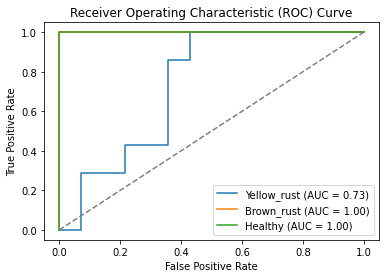

In [10]:
# from google.colab import files
# uploaded = files.upload()
# from google.colab import drive
# drive.mount('/content/drive/')
import os
import cv2
import numpy as np
import tensorflow as tf
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold
from keras.metrics import AUC
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from patchify import patchify
# import tensorflow_hub as hub
# Assuming you have already imported or defined the ViT model
# ...
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
#from project import ViT
hp = {
    "image_size": 512,
    "num_channels": 3,
    "patch_size": 64,
    "num_classes": 3,
    "class_names": ["Yellow_rust","Brown_rust", "Healthy"],
    "num_layers": 24,
    "hidden_dim": 256,
    "mlp_dim": 1024,
    "num_heads": 4,
    "dropout_rate": 0.1,
    "batch_size": 16,
    "lr": 1e-4,
    "num_epochs": 1
}
hp["num_patches"] = (hp["image_size"] ** 2) // (hp["patch_size"] ** 2)
hp["flat_patches_shape"] = (hp["num_patches"], hp["patch_size"] * hp["patch_size"] * hp["num_channels"])


def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)


def load_data(path, split=0.20):
    images = glob(os.path.join(path, "*", "*.jpg"))

    # Separate images by class
    images_class_BKL = [image for image in images if "Yellow_rust" in image]
    images_class_NV = [image for image in images if "Brown_rust" in image]
    images_class_MEL2 = [image for image in images if "Healthy" in image]

    # Oversample to 33,000 to match the largest class (BKL)
    target_size = len(images_class_BKL)
    #print(images_class_BKL)
    images_class_NV = np.random.choice(images_class_NV, size=target_size, replace=True).tolist()
    images_class_MEL2 = np.random.choice(images_class_MEL2, size=target_size, replace=True).tolist()

    # Concatenate lists again and shuffle
    images = shuffle(images_class_BKL + images_class_NV + images_class_MEL2)

    split_size = int(len(images) * split)
    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    print(f"Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")

    return train_x, valid_x, test_x


def process_image_label(path):
    path = path.decode()
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (hp["image_size"], hp["image_size"]))
    image = image / 255.0

    patch_shape = (hp["patch_size"], hp["patch_size"], hp["num_channels"])
    patches = patchify(image, patch_shape, hp["patch_size"])
    patches = np.reshape(patches, hp["flat_patches_shape"])
    patches = patches.astype(np.float32)

    class_name = path.split("/")[-2]
    class_idx = hp["class_names"].index(class_name)
    class_idx = np.array(class_idx, dtype=np.int32)
    return patches, class_idx


def parse(path):
    patches, labels = tf.numpy_function(process_image_label, [path], [tf.float32, tf.int32])
    labels = tf.one_hot(labels, hp["num_classes"])

    patches.set_shape(hp["flat_patches_shape"])
    labels.set_shape(hp["num_classes"])

    return patches, labels


def tf_dataset(images, batch=32):
    ds = tf.data.Dataset.from_tensor_slices((images))
    ds = ds.map(parse).batch(batch).prefetch(8)
    return ds


def get_model():
    model = ViT(hp)
    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(hp["lr"], clipvalue=1.0),
        metrics=["acc", AUC(name='auc', multi_label=True)]
    )
    return model


if __name__ == "__main__":
    create_dir("files")
    dataset_path = '/home/ali/Music/PYTHON/DS'
    model_path = os.path.join("files", "model3.h5")
    csv_path = os.path.join("files", "log2.csv")
    train_x, valid_x, test_x = load_data(dataset_path)
    images = train_x + valid_x
    print(f"Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_no = 1

    for train, val in kfold.split(images):
        print(f'Training for fold {fold_no} ...')
        train_ds = tf_dataset(np.array(images)[train], batch=hp["batch_size"])
        valid_ds = tf_dataset(np.array(images)[val], batch=hp["batch_size"])
        model = get_model()
        callbacks = [
            ModelCheckpoint(f"files/modelN_fold{fold_no}.h5", monitor='val_loss', verbose=1, save_best_only=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-10, verbose=1),
            CSVLogger(f"files/log2_fold{fold_no}.csv"),
            EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False),
        ]
        print(2)
        model.fit(train_ds, epochs=hp["num_epochs"], validation_data=valid_ds, callbacks=callbacks)
        fold_no += 1
        print(3)

    # Evaluating on the test set
    print("Evaluating the test set...")
    test_ds = tf_dataset(test_x, batch=hp["batch_size"])
    all_preds = []
    custom_objects = {"ClassToken": ClassToken}
    for fold_no in range(1, 6):
        with tf.keras.utils.custom_object_scope(custom_objects):
            fold_model = tf.keras.models.load_model(f"files/modelN_fold{fold_no}.h5")
        y_pred_probs = fold_model.predict(test_ds)
        all_preds.append(y_pred_probs)

    avg_preds = np.mean(all_preds, axis=0)
    final_preds = np.argmax(avg_preds, axis=1)
    y_true = [hp["class_names"].index(img.split("/")[-2]) for img in test_x]
    print(classification_report(y_true, final_preds, target_names=hp["class_names"]))
    roc_aucs = []

    for i, class_name in enumerate(hp["class_names"]):
        auc_val = roc_auc_score((np.array(y_true) == i).astype(int), avg_preds[:, i])
        roc_aucs.append(auc_val)
        print(f"AUC-ROC ({class_name}): {auc_val:.4f}")

    for i, class_name in enumerate(hp["class_names"]):
        fpr, tpr, _ = roc_curve((np.array(y_true) == i).astype(int), avg_preds[:, i])
        plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_aucs[i]:.2f})")

    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

Train: 2083 - Valid: 694 - Test: 694
Train: 2083 - Valid: 694 - Test: 694
Training for fold 1 ...
2
139/139 [==============================] - ETA: 0s - loss: 1.2528 - acc: 0.3679 - auc: 0.5354
Epoch 1: val_loss improved from inf to 1.17410, saving model to files/modelN_fold1.h5


/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


139/139 [==============================] - 1017s 7s/step - loss: 1.2528 - acc: 0.3679 - auc: 0.5354 - val_loss: 1.1741 - val_acc: 0.3129 - val_auc: 0.7422 - lr: 1.0000e-04
3
Training for fold 2 ...
2
139/139 [==============================] - ETA: 0s - loss: 1.2627 - acc: 0.3543 - auc: 0.5284
Epoch 1: val_loss improved from inf to 1.02183, saving model to files/modelN_fold2.h5
139/139 [==============================] - 1017s 7s/step - loss: 1.2627 - acc: 0.3543 - auc: 0.5284 - val_loss: 1.0218 - val_acc: 0.4227 - val_auc: 0.7840 - lr: 1.0000e-04
3
Training for fold 3 ...
2
139/139 [==============================] - ETA: 0s - loss: 1.1983 - acc: 0.3947 - auc: 0.5605
Epoch 1: val_loss improved from inf to 0.81027, saving model to files/modelN_fold3.h5
139/139 [==============================] - 1013s 7s/step - loss: 1.1983 - acc: 0.3947 - auc: 0.5605 - val_loss: 0.8103 - val_acc: 0.6450 - val_auc: 0.8551 - lr: 1.0000e-04
3
Training for fold 4 ...
2
139/139 [==============================]

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

 Yellow_rust       0.00      0.00      0.00       218
  Brown_rust       0.95      0.41      0.57       218
     Healthy       0.43      1.00      0.60       258

    accuracy                           0.50       694
   macro avg       0.46      0.47      0.39       694
weighted avg       0.46      0.50      0.40       694

AUC-ROC (Yellow_rust): 0.8322
AUC-ROC (Brown_rust): 0.8680
AUC-ROC (Healthy): 0.8785


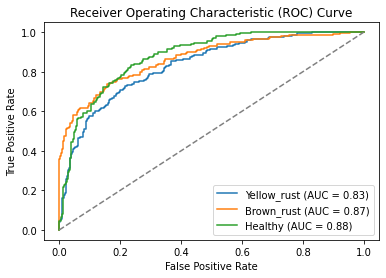

In [14]:
# from google.colab import files
# uploaded = files.upload()
# from google.colab import drive
# drive.mount('/content/drive/')
import os
import cv2
import numpy as np
import tensorflow as tf
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold
from keras.metrics import AUC
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from patchify import patchify
# import tensorflow_hub as hub
# Assuming you have already imported or defined the ViT model
# ...
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
#from project import ViT
hp = {
    "image_size": 512,
    "num_channels": 3,
    "patch_size": 64,
    "num_classes": 3,
    "class_names": ["Yellow_rust","Brown_rust", "Healthy"],
    "num_layers": 24,
    "hidden_dim": 256,
    "mlp_dim": 1024,
    "num_heads": 4,
    "dropout_rate": 0.1,
    "batch_size": 16,
    "lr": 1e-4,
    "num_epochs": 1
}
hp["num_patches"] = (hp["image_size"] ** 2) // (hp["patch_size"] ** 2)
hp["flat_patches_shape"] = (hp["num_patches"], hp["patch_size"] * hp["patch_size"] * hp["num_channels"])


def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)


def load_data(path, split=0.20):
    images = glob(os.path.join(path, "*", "*.jpg"))

    # Separate images by class
    images_class_BKL = [image for image in images if "Yellow_rust" in image]
    images_class_NV = [image for image in images if "Brown_rust" in image]
    images_class_MEL2 = [image for image in images if "Healthy" in image]

    # Oversample to 33,000 to match the largest class (BKL)
    target_size = len(images_class_BKL)
    #print(images_class_BKL)
    images_class_NV = np.random.choice(images_class_NV, size=target_size, replace=True).tolist()
    images_class_MEL2 = np.random.choice(images_class_MEL2, size=target_size, replace=True).tolist()

    # Concatenate lists again and shuffle
    images = shuffle(images_class_BKL + images_class_NV + images_class_MEL2)

    split_size = int(len(images) * split)
    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    print(f"Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")

    return train_x, valid_x, test_x


def process_image_label(path):
    path = path.decode()
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (hp["image_size"], hp["image_size"]))
    image = image / 255.0

    patch_shape = (hp["patch_size"], hp["patch_size"], hp["num_channels"])
    patches = patchify(image, patch_shape, hp["patch_size"])
    patches = np.reshape(patches, hp["flat_patches_shape"])
    patches = patches.astype(np.float32)

    class_name = path.split("/")[-2]
    class_idx = hp["class_names"].index(class_name)
    class_idx = np.array(class_idx, dtype=np.int32)
    return patches, class_idx


def parse(path):
    patches, labels = tf.numpy_function(process_image_label, [path], [tf.float32, tf.int32])
    labels = tf.one_hot(labels, hp["num_classes"])

    patches.set_shape(hp["flat_patches_shape"])
    labels.set_shape(hp["num_classes"])

    return patches, labels


def tf_dataset(images, batch=32):
    ds = tf.data.Dataset.from_tensor_slices((images))
    ds = ds.map(parse).batch(batch).prefetch(8)
    return ds


def get_model():
    model = ViT(hp)
    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(hp["lr"], clipvalue=1.0),
        metrics=["acc", AUC(name='auc', multi_label=True)]
    )
    return model


if __name__ == "__main__":
    create_dir("files")
    dataset_path = '/home/ali/Music/PYTHON/WholeDataset'
    model_path = os.path.join("files", "model3.h5")
    csv_path = os.path.join("files", "log2.csv")
    train_x, valid_x, test_x = load_data(dataset_path)
    images = train_x + valid_x
    print(f"Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_no = 1

    for train, val in kfold.split(images):
        print(f'Training for fold {fold_no} ...')
        train_ds = tf_dataset(np.array(images)[train], batch=hp["batch_size"])
        valid_ds = tf_dataset(np.array(images)[val], batch=hp["batch_size"])
        model = get_model()
        callbacks = [
            ModelCheckpoint(f"files/modelN_fold{fold_no}.h5", monitor='val_loss', verbose=1, save_best_only=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-10, verbose=1),
            CSVLogger(f"files/log2_fold{fold_no}.csv"),
            EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False),
        ]
        print(2)
        model.fit(train_ds, epochs=hp["num_epochs"], validation_data=valid_ds, callbacks=callbacks)
        fold_no += 1
        print(3)

    # Evaluating on the test set
    print("Evaluating the test set...")
    test_ds = tf_dataset(test_x, batch=hp["batch_size"])
    all_preds = []
    custom_objects = {"ClassToken": ClassToken}
    for fold_no in range(1, 6):
        with tf.keras.utils.custom_object_scope(custom_objects):
            fold_model = tf.keras.models.load_model(f"files/modelN_fold{fold_no}.h5")
        y_pred_probs = fold_model.predict(test_ds)
        all_preds.append(y_pred_probs)

    avg_preds = np.mean(all_preds, axis=0)
    final_preds = np.argmax(avg_preds, axis=1)
    y_true = [hp["class_names"].index(img.split("/")[-2]) for img in test_x]
    print(classification_report(y_true, final_preds, target_names=hp["class_names"]))
    roc_aucs = []

    for i, class_name in enumerate(hp["class_names"]):
        auc_val = roc_auc_score((np.array(y_true) == i).astype(int), avg_preds[:, i])
        roc_aucs.append(auc_val)
        print(f"AUC-ROC ({class_name}): {auc_val:.4f}")

    for i, class_name in enumerate(hp["class_names"]):
        fpr, tpr, _ = roc_curve((np.array(y_true) == i).astype(int), avg_preds[:, i])
        plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_aucs[i]:.2f})")

    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

Train: 2083 - Valid: 694 - Test: 694
Train: 2083 - Valid: 694 - Test: 694
Training for fold 1 ...
2
Epoch 1/10
139/139 [==============================] - ETA: 0s - loss: 1.2986 - acc: 0.3516 - auc: 0.5258
Epoch 1: val_loss improved from inf to 1.06386, saving model to files/modelN_fold1.h5


/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


139/139 [==============================] - 1005s 7s/step - loss: 1.2986 - acc: 0.3516 - auc: 0.5258 - val_loss: 1.0639 - val_acc: 0.4065 - val_auc: 0.6795 - lr: 1.0000e-04
Epoch 2/10
139/139 [==============================] - ETA: 0s - loss: 0.9857 - acc: 0.4840 - auc: 0.6872
Epoch 2: val_loss improved from 1.06386 to 0.82759, saving model to files/modelN_fold1.h5
139/139 [==============================] - 979s 7s/step - loss: 0.9857 - acc: 0.4840 - auc: 0.6872 - val_loss: 0.8276 - val_acc: 0.5252 - val_auc: 0.8448 - lr: 1.0000e-04
Epoch 3/10
139/139 [==============================] - ETA: 0s - loss: 0.7221 - acc: 0.6749 - auc: 0.8477
Epoch 3: val_loss improved from 0.82759 to 0.51293, saving model to files/modelN_fold1.h5
139/139 [==============================] - 977s 7s/step - loss: 0.7221 - acc: 0.6749 - auc: 0.8477 - val_loss: 0.5129 - val_acc: 0.8129 - val_auc: 0.9376 - lr: 1.0000e-04
Epoch 4/10
139/139 [==============================] - ETA: 0s - loss: 0.5523 - acc: 0.7789 - auc

Epoch 5/10
139/139 [==============================] - ETA: 0s - loss: 0.3131 - acc: 0.8870 - auc: 0.9717
Epoch 5: val_loss improved from 0.35833 to 0.33927, saving model to files/modelN_fold3.h5
139/139 [==============================] - 949s 7s/step - loss: 0.3131 - acc: 0.8870 - auc: 0.9717 - val_loss: 0.3393 - val_acc: 0.8559 - val_auc: 0.9818 - lr: 1.0000e-04
Epoch 6/10
139/139 [==============================] - ETA: 0s - loss: 0.2698 - acc: 0.9001 - auc: 0.9793
Epoch 6: val_loss improved from 0.33927 to 0.20299, saving model to files/modelN_fold3.h5
139/139 [==============================] - 957s 7s/step - loss: 0.2698 - acc: 0.9001 - auc: 0.9793 - val_loss: 0.2030 - val_acc: 0.9153 - val_auc: 0.9904 - lr: 1.0000e-04
Epoch 7/10
139/139 [==============================] - ETA: 0s - loss: 0.1952 - acc: 0.9329 - auc: 0.9885
Epoch 7: val_loss improved from 0.20299 to 0.19675, saving model to files/modelN_fold3.h5
139/139 [==============================] - 976s 7s/step - loss: 0.1952 - 

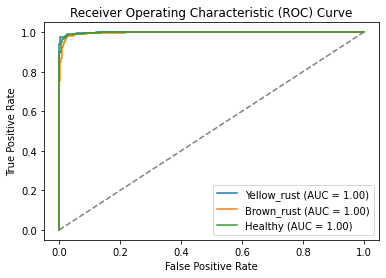

In [15]:
# from google.colab import files
# uploaded = files.upload()
# from google.colab import drive
# drive.mount('/content/drive/')
import os
import cv2
import numpy as np
import tensorflow as tf
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold
from keras.metrics import AUC
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from patchify import patchify
# import tensorflow_hub as hub
# Assuming you have already imported or defined the ViT model
# ...
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
#from project import ViT
hp = {
    "image_size": 512,
    "num_channels": 3,
    "patch_size": 64,
    "num_classes": 3,
    "class_names": ["Yellow_rust","Brown_rust", "Healthy"],
    "num_layers": 24,
    "hidden_dim": 256,
    "mlp_dim": 1024,
    "num_heads": 4,
    "dropout_rate": 0.1,
    "batch_size": 16,
    "lr": 1e-4,
    "num_epochs": 10
}
hp["num_patches"] = (hp["image_size"] ** 2) // (hp["patch_size"] ** 2)
hp["flat_patches_shape"] = (hp["num_patches"], hp["patch_size"] * hp["patch_size"] * hp["num_channels"])


def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)


def load_data(path, split=0.20):
    images = glob(os.path.join(path, "*", "*.jpg"))

    # Separate images by class
    images_class_BKL = [image for image in images if "Yellow_rust" in image]
    images_class_NV = [image for image in images if "Brown_rust" in image]
    images_class_MEL2 = [image for image in images if "Healthy" in image]
    images_class_MEL2 = [image for image in images if "Healthy" in image]

    # Oversample to 33,000 to match the largest class (BKL)
    target_size = len(images_class_BKL)
    #print(images_class_BKL)
    images_class_NV = np.random.choice(images_class_NV, size=target_size, replace=True).tolist()
    images_class_MEL2 = np.random.choice(images_class_MEL2, size=target_size, replace=True).tolist()

    # Concatenate lists again and shuffle
    images = shuffle(images_class_BKL + images_class_NV + images_class_MEL2)

    split_size = int(len(images) * split)
    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    print(f"Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")

    return train_x, valid_x, test_x


def process_image_label(path):
    path = path.decode()
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (hp["image_size"], hp["image_size"]))
    image = image / 255.0

    patch_shape = (hp["patch_size"], hp["patch_size"], hp["num_channels"])
    patches = patchify(image, patch_shape, hp["patch_size"])
    patches = np.reshape(patches, hp["flat_patches_shape"])
    patches = patches.astype(np.float32)

    class_name = path.split("/")[-2]
    class_idx = hp["class_names"].index(class_name)
    class_idx = np.array(class_idx, dtype=np.int32)
    return patches, class_idx


def parse(path):
    patches, labels = tf.numpy_function(process_image_label, [path], [tf.float32, tf.int32])
    labels = tf.one_hot(labels, hp["num_classes"])

    patches.set_shape(hp["flat_patches_shape"])
    labels.set_shape(hp["num_classes"])

    return patches, labels


def tf_dataset(images, batch=32):
    ds = tf.data.Dataset.from_tensor_slices((images))
    ds = ds.map(parse).batch(batch).prefetch(8)
    return ds


def get_model():
    model = ViT(hp)
    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(hp["lr"], clipvalue=1.0),
        metrics=["acc", AUC(name='auc', multi_label=True)]
    )
    return model


if __name__ == "__main__":
    create_dir("files")
    dataset_path = '/home/ali/Music/PYTHON/WholeDataset'
    model_path = os.path.join("files", "model3.h5")
    csv_path = os.path.join("files", "log2.csv")
    train_x, valid_x, test_x = load_data(dataset_path)
    images = train_x + valid_x
    print(f"Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_no = 1

    for train, val in kfold.split(images):
        print(f'Training for fold {fold_no} ...')
        train_ds = tf_dataset(np.array(images)[train], batch=hp["batch_size"])
        valid_ds = tf_dataset(np.array(images)[val], batch=hp["batch_size"])
        model = get_model()
        callbacks = [
            ModelCheckpoint(f"files/modelN_fold{fold_no}.h5", monitor='val_loss', verbose=1, save_best_only=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-10, verbose=1),
            CSVLogger(f"files/log2_fold{fold_no}.csv"),
            EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False),
        ]
        print(2)
        model.fit(train_ds, epochs=hp["num_epochs"], validation_data=valid_ds, callbacks=callbacks)
        fold_no += 1
        print(3)

    # Evaluating on the test set
    print("Evaluating the test set...")
    test_ds = tf_dataset(test_x, batch=hp["batch_size"])
    all_preds = []
    custom_objects = {"ClassToken": ClassToken}
    for fold_no in range(1, 6):
        with tf.keras.utils.custom_object_scope(custom_objects):
            fold_model = tf.keras.models.load_model(f"files/modelN_fold{fold_no}.h5")
        y_pred_probs = fold_model.predict(test_ds)
        all_preds.append(y_pred_probs)

    avg_preds = np.mean(all_preds, axis=0)
    final_preds = np.argmax(avg_preds, axis=1)
    y_true = [hp["class_names"].index(img.split("/")[-2]) for img in test_x]
    print(classification_report(y_true, final_preds, target_names=hp["class_names"]))
    roc_aucs = []

    for i, class_name in enumerate(hp["class_names"]):
        auc_val = roc_auc_score((np.array(y_true) == i).astype(int), avg_preds[:, i])
        roc_aucs.append(auc_val)
        print(f"AUC-ROC ({class_name}): {auc_val:.4f}")

    for i, class_name in enumerate(hp["class_names"]):
        fpr, tpr, _ = roc_curve((np.array(y_true) == i).astype(int), avg_preds[:, i])
        plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_aucs[i]:.2f})")

    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_26 (InputLayer)       [(None, 256, 3072)]          0         []                            
                                                                                                  
 dense_1250 (Dense)          (None, 256, 256)             786688    ['input_26[0][0]']            
                                                                                                  
 tf.__operators__.add_30 (T  (None, 256, 256)             0         ['dense_1250[0][0]']          
 FOpLambda)                                                                                       
                                                                                                  
 class_token_61 (ClassToken  (None, 1, 256)               256       ['tf.__operators__.add_

 layer_normalization_1230 (  (None, 257, 256)             512       ['add_1204[0][0]']            
 LayerNormalization)                                                                              
                                                                                                  
 dense_1255 (Dense)          (None, 257, 1024)            263168    ['layer_normalization_1230[0][
                                                                    0]']                          
                                                                                                  
 dropout_2068 (Dropout)      (None, 257, 1024)            0         ['dense_1255[0][0]']          
                                                                                                  
 dense_1256 (Dense)          (None, 257, 256)             262400    ['dropout_2068[0][0]']        
                                                                                                  
 dropout_2

                                                                                                  
 dense_1261 (Dense)          (None, 257, 1024)            263168    ['layer_normalization_1236[0][
                                                                    0]']                          
                                                                                                  
 dropout_2074 (Dropout)      (None, 257, 1024)            0         ['dense_1261[0][0]']          
                                                                                                  
 dense_1262 (Dense)          (None, 257, 256)             262400    ['dropout_2074[0][0]']        
                                                                                                  
 dropout_2075 (Dropout)      (None, 257, 256)             0         ['dense_1262[0][0]']          
                                                                                                  
 add_1211 

                                                                    0]']                          
                                                                                                  
 dropout_2080 (Dropout)      (None, 257, 1024)            0         ['dense_1267[0][0]']          
                                                                                                  
 dense_1268 (Dense)          (None, 257, 256)             262400    ['dropout_2080[0][0]']        
                                                                                                  
 dropout_2081 (Dropout)      (None, 257, 256)             0         ['dense_1268[0][0]']          
                                                                                                  
 add_1217 (Add)              (None, 257, 256)             0         ['dropout_2081[0][0]',        
                                                                     'add_1216[0][0]']            
          

 dropout_2086 (Dropout)      (None, 257, 1024)            0         ['dense_1273[0][0]']          
                                                                                                  
 dense_1274 (Dense)          (None, 257, 256)             262400    ['dropout_2086[0][0]']        
                                                                                                  
 dropout_2087 (Dropout)      (None, 257, 256)             0         ['dense_1274[0][0]']          
                                                                                                  
 add_1223 (Add)              (None, 257, 256)             0         ['dropout_2087[0][0]',        
                                                                     'add_1222[0][0]']            
                                                                                                  
 layer_normalization_1249 (  (None, 257, 256)             512       ['add_1223[0][0]']            
 LayerNorm

 dense_1280 (Dense)          (None, 257, 256)             262400    ['dropout_2092[0][0]']        
                                                                                                  
 dropout_2093 (Dropout)      (None, 257, 256)             0         ['dense_1280[0][0]']          
                                                                                                  
 add_1229 (Add)              (None, 257, 256)             0         ['dropout_2093[0][0]',        
                                                                     'add_1228[0][0]']            
                                                                                                  
 layer_normalization_1255 (  (None, 257, 256)             512       ['add_1229[0][0]']            
 LayerNormalization)                                                                              
                                                                                                  
 multi_hea

 dropout_2099 (Dropout)      (None, 257, 256)             0         ['dense_1286[0][0]']          
                                                                                                  
 add_1235 (Add)              (None, 257, 256)             0         ['dropout_2099[0][0]',        
                                                                     'add_1234[0][0]']            
                                                                                                  
 layer_normalization_1261 (  (None, 257, 256)             512       ['add_1235[0][0]']            
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_618 (  (None, 257, 256)             3155200   ['layer_normalization_1261[0][
 MultiHeadAttention)                                                0]',                          
          

 add_1241 (Add)              (None, 257, 256)             0         ['dropout_2105[0][0]',        
                                                                     'add_1240[0][0]']            
                                                                                                  
 layer_normalization_1267 (  (None, 257, 256)             512       ['add_1241[0][0]']            
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_621 (  (None, 257, 256)             3155200   ['layer_normalization_1267[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_1267[0][
                                                                    0]']                          
          

                                                                                                  
 layer_normalization_1273 (  (None, 257, 256)             512       ['add_1247[0][0]']            
 LayerNormalization)                                                                              
                                                                                                  
 tf.__operators__.getitem_3  (None, 256)                  0         ['layer_normalization_1273[0][
 0 (SlicingOpLambda)                                                0]']                          
                                                                                                  
 dense_1299 (Dense)          (None, 4)                    1028      ['tf.__operators__.getitem_30[
                                                                    0][0]']                       
                                                                                                  
Total para

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


186/186 [==============================] - 1371s 7s/step - loss: 0.9403 - acc: 0.6063 - auc: 0.8351 - val_loss: 0.6578 - val_acc: 0.7099 - val_auc: 0.9205 - lr: 1.0000e-04
3
Training for fold 2 ...
2
186/186 [==============================] - ETA: 0s - loss: 1.2056 - acc: 0.4646 - auc: 0.7268
Epoch 1: val_loss improved from inf to 0.77241, saving model to files/modelN_fold2.h5
186/186 [==============================] - 1421s 7s/step - loss: 1.2056 - acc: 0.4646 - auc: 0.7268 - val_loss: 0.7724 - val_acc: 0.6289 - val_auc: 0.9205 - lr: 1.0000e-04
3
Training for fold 3 ...
2
186/186 [==============================] - ETA: 0s - loss: 1.1700 - acc: 0.4892 - auc: 0.7544
Epoch 1: val_loss improved from inf to 0.63868, saving model to files/modelN_fold3.h5
186/186 [==============================] - 1348s 7s/step - loss: 1.1700 - acc: 0.4892 - auc: 0.7544 - val_loss: 0.6387 - val_acc: 0.7139 - val_auc: 0.9274 - lr: 1.0000e-04
3
Training for fold 4 ...
2
186/186 [==============================]

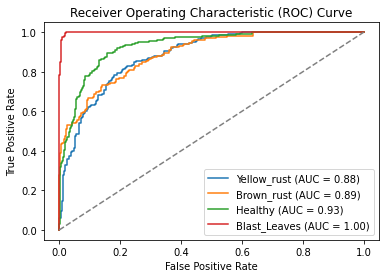

In [16]:
# 1 Epoch train and test
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import Model

class ClassToken(Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value = w_init(shape=(1, 1, input_shape[-1]), dtype=tf.float32),
            trainable = True
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        hidden_dim = self.w.shape[-1]

        cls = tf.broadcast_to(self.w, [batch_size, 1, hidden_dim])
        cls = tf.cast(cls, dtype=inputs.dtype)
        return cls

def mlp(x, cf):
    x = Dense(cf["mlp_dim"], activation="gelu")(x)
    x = Dropout(cf["dropout_rate"])(x)
    x = Dense(cf["hidden_dim"])(x)
    x = Dropout(cf["dropout_rate"])(x)
    return x

def transformer_encoder(x, cf):
    skip_1 = x
    x = LayerNormalization()(x)
    x = MultiHeadAttention(
        num_heads=cf["num_heads"], key_dim=cf["hidden_dim"]
    )(x, x)
    x = Add()([x, skip_1])

    skip_2 = x
    x = LayerNormalization()(x)
    x = mlp(x, cf)
    x = Add()([x, skip_2])

    return x

def ViT(cf):
    """ Inputs """
    input_shape = (cf["num_patches"], cf["patch_size"]*cf["patch_size"]*cf["num_channels"])
    inputs = Input(input_shape)     ## (None, 256, 3072)

    """ Patch + Position Embeddings """
    patch_embed = Dense(cf["hidden_dim"])(inputs)   ## (None, 256, 768)

    positions = tf.range(start=0, limit=cf["num_patches"], delta=1)
    pos_embed = Embedding(input_dim=cf["num_patches"], output_dim=cf["hidden_dim"])(positions) ## (256, 768)
    embed = patch_embed + pos_embed ## (None, 256, 768)

    """ Adding Class Token """
    token = ClassToken()(embed)
    x = Concatenate(axis=1)([token, embed]) ## (None, 257, 768)

    for _ in range(cf["num_layers"]):
        x = transformer_encoder(x, cf)

    """ Classification Head """
    x = LayerNormalization()(x)     ## (None, 257, 768)
    x = x[:, 0, :]
    x = Dense(cf["num_classes"], activation="softmax")(x)

    model = Model(inputs, x)
    return model


if __name__ == "__main__":
    config = {}
    config["num_layers"] = 24
#     config["hidden_dim"] = 768
#     config["mlp_dim"] =3072
    config["num_heads"] = 12
    config["dropout_rate"] = 0.1
    config["num_patches"] = 256
    config["patch_size"] = 32
    config["num_channels"] = 3
    config["num_classes"] = 4

    config["hidden_dim"] = 256
    config["mlp_dim"] = 1024  

    model = ViT(config)
    model.summary()


# from google.colab import files
# uploaded = files.upload()
# from google.colab import drive
# drive.mount('/content/drive/')
import os
import cv2
import numpy as np
import tensorflow as tf
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold
from keras.metrics import AUC
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from patchify import patchify
# import tensorflow_hub as hub
# Assuming you have already imported or defined the ViT model
# ...
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
#from project import ViT
hp = {
    "image_size": 512,
    "num_channels": 3,
    "patch_size": 64,
    "num_classes": 4,
    "class_names": ["Yellow_rust","Brown_rust", "Healthy","Blast_Leaves"],
    "num_layers": 24,
    "hidden_dim": 256,
    "mlp_dim": 1024,
    "num_heads": 4,
    "dropout_rate": 0.1,
    "batch_size": 16,
    "lr": 1e-4,
    "num_epochs": 1
}
hp["num_patches"] = (hp["image_size"] ** 2) // (hp["patch_size"] ** 2)
hp["flat_patches_shape"] = (hp["num_patches"], hp["patch_size"] * hp["patch_size"] * hp["num_channels"])


def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)


def load_data(path, split=0.20):
    images = glob(os.path.join(path, "*", "*.jpg"))

    # Separate images by class
    images_class_BKL = [image for image in images if "Yellow_rust" in image]
    images_class_NV = [image for image in images if "Brown_rust" in image]
    images_class_MEL2 = [image for image in images if "Healthy" in image]
    images_class_BlastLeaves = [image for image in images if "Blast_Leaves" in image]

    # Oversample to 33,000 to match the largest class (BKL)
    target_size = len(images_class_BKL)
    #print(images_class_BKL)
    images_class_NV = np.random.choice(images_class_NV, size=target_size, replace=True).tolist()
    images_class_MEL2 = np.random.choice(images_class_MEL2, size=target_size, replace=True).tolist()
    images_class_BlastLeaves = np.random.choice(images_class_BlastLeaves, size=target_size, replace=True).tolist()
    # Concatenate lists again and shuffle
    images = shuffle(images_class_BKL + images_class_NV + images_class_MEL2+ images_class_BlastLeaves)

    split_size = int(len(images) * split)
    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    print(f"Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")

    return train_x, valid_x, test_x


def process_image_label(path):
    path = path.decode()
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (hp["image_size"], hp["image_size"]))
    image = image / 255.0

    patch_shape = (hp["patch_size"], hp["patch_size"], hp["num_channels"])
    patches = patchify(image, patch_shape, hp["patch_size"])
    patches = np.reshape(patches, hp["flat_patches_shape"])
    patches = patches.astype(np.float32)

    class_name = path.split("/")[-2]
    class_idx = hp["class_names"].index(class_name)
    class_idx = np.array(class_idx, dtype=np.int32)
    return patches, class_idx


def parse(path):
    patches, labels = tf.numpy_function(process_image_label, [path], [tf.float32, tf.int32])
    labels = tf.one_hot(labels, hp["num_classes"])

    patches.set_shape(hp["flat_patches_shape"])
    labels.set_shape(hp["num_classes"])

    return patches, labels


def tf_dataset(images, batch=32):
    ds = tf.data.Dataset.from_tensor_slices((images))
    ds = ds.map(parse).batch(batch).prefetch(8)
    return ds


def get_model():
    model = ViT(hp)
    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(hp["lr"], clipvalue=1.0),
        metrics=["acc", AUC(name='auc', multi_label=True)]
    )
    return model


if __name__ == "__main__":
    create_dir("files")
    dataset_path = '/home/ali/Music/PYTHON/WholeDataset'
    model_path = os.path.join("files", "model3.h5")
    csv_path = os.path.join("files", "log2.csv")
    train_x, valid_x, test_x = load_data(dataset_path)
    images = train_x + valid_x
    print(f"Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_no = 1

    for train, val in kfold.split(images):
        print(f'Training for fold {fold_no} ...')
        train_ds = tf_dataset(np.array(images)[train], batch=hp["batch_size"])
        valid_ds = tf_dataset(np.array(images)[val], batch=hp["batch_size"])
        model = get_model()
        callbacks = [
            ModelCheckpoint(f"files/modelN_fold{fold_no}.h5", monitor='val_loss', verbose=1, save_best_only=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-10, verbose=1),
            CSVLogger(f"files/log2_fold{fold_no}.csv"),
            EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False),
        ]
        print(2)
        model.fit(train_ds, epochs=hp["num_epochs"], validation_data=valid_ds, callbacks=callbacks)
        fold_no += 1
        print(3)

    # Evaluating on the test set
    print("Evaluating the test set...")
    test_ds = tf_dataset(test_x, batch=hp["batch_size"])
    all_preds = []
    custom_objects = {"ClassToken": ClassToken}
    for fold_no in range(1, 6):
        with tf.keras.utils.custom_object_scope(custom_objects):
            fold_model = tf.keras.models.load_model(f"files/modelN_fold{fold_no}.h5")
        y_pred_probs = fold_model.predict(test_ds)
        all_preds.append(y_pred_probs)

    avg_preds = np.mean(all_preds, axis=0)
    final_preds = np.argmax(avg_preds, axis=1)
    y_true = [hp["class_names"].index(img.split("/")[-2]) for img in test_x]
    print(classification_report(y_true, final_preds, target_names=hp["class_names"]))
    roc_aucs = []

    for i, class_name in enumerate(hp["class_names"]):
        auc_val = roc_auc_score((np.array(y_true) == i).astype(int), avg_preds[:, i])
        roc_aucs.append(auc_val)
        print(f"AUC-ROC ({class_name}): {auc_val:.4f}")

    for i, class_name in enumerate(hp["class_names"]):
        fpr, tpr, _ = roc_curve((np.array(y_true) == i).astype(int), avg_preds[:, i])
        plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_aucs[i]:.2f})")

    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_32 (InputLayer)       [(None, 256, 3072)]          0         []                            
                                                                                                  
 dense_1550 (Dense)          (None, 256, 256)             786688    ['input_32[0][0]']            
                                                                                                  
 tf.__operators__.add_36 (T  (None, 256, 256)             0         ['dense_1550[0][0]']          
 FOpLambda)                                                                                       
                                                                                                  
 class_token_72 (ClassToken  (None, 1, 256)               256       ['tf.__operators__.add_

 layer_normalization_1524 (  (None, 257, 256)             512       ['add_1492[0][0]']            
 LayerNormalization)                                                                              
                                                                                                  
 dense_1555 (Dense)          (None, 257, 1024)            263168    ['layer_normalization_1524[0][
                                                                    0]']                          
                                                                                                  
 dropout_2476 (Dropout)      (None, 257, 1024)            0         ['dense_1555[0][0]']          
                                                                                                  
 dense_1556 (Dense)          (None, 257, 256)             262400    ['dropout_2476[0][0]']        
                                                                                                  
 dropout_2

                                                                                                  
 dense_1561 (Dense)          (None, 257, 1024)            263168    ['layer_normalization_1530[0][
                                                                    0]']                          
                                                                                                  
 dropout_2482 (Dropout)      (None, 257, 1024)            0         ['dense_1561[0][0]']          
                                                                                                  
 dense_1562 (Dense)          (None, 257, 256)             262400    ['dropout_2482[0][0]']        
                                                                                                  
 dropout_2483 (Dropout)      (None, 257, 256)             0         ['dense_1562[0][0]']          
                                                                                                  
 add_1499 

                                                                    0]']                          
                                                                                                  
 dropout_2488 (Dropout)      (None, 257, 1024)            0         ['dense_1567[0][0]']          
                                                                                                  
 dense_1568 (Dense)          (None, 257, 256)             262400    ['dropout_2488[0][0]']        
                                                                                                  
 dropout_2489 (Dropout)      (None, 257, 256)             0         ['dense_1568[0][0]']          
                                                                                                  
 add_1505 (Add)              (None, 257, 256)             0         ['dropout_2489[0][0]',        
                                                                     'add_1504[0][0]']            
          

 dropout_2494 (Dropout)      (None, 257, 1024)            0         ['dense_1573[0][0]']          
                                                                                                  
 dense_1574 (Dense)          (None, 257, 256)             262400    ['dropout_2494[0][0]']        
                                                                                                  
 dropout_2495 (Dropout)      (None, 257, 256)             0         ['dense_1574[0][0]']          
                                                                                                  
 add_1511 (Add)              (None, 257, 256)             0         ['dropout_2495[0][0]',        
                                                                     'add_1510[0][0]']            
                                                                                                  
 layer_normalization_1543 (  (None, 257, 256)             512       ['add_1511[0][0]']            
 LayerNorm

 dense_1580 (Dense)          (None, 257, 256)             262400    ['dropout_2500[0][0]']        
                                                                                                  
 dropout_2501 (Dropout)      (None, 257, 256)             0         ['dense_1580[0][0]']          
                                                                                                  
 add_1517 (Add)              (None, 257, 256)             0         ['dropout_2501[0][0]',        
                                                                     'add_1516[0][0]']            
                                                                                                  
 layer_normalization_1549 (  (None, 257, 256)             512       ['add_1517[0][0]']            
 LayerNormalization)                                                                              
                                                                                                  
 multi_hea

 dropout_2507 (Dropout)      (None, 257, 256)             0         ['dense_1586[0][0]']          
                                                                                                  
 add_1523 (Add)              (None, 257, 256)             0         ['dropout_2507[0][0]',        
                                                                     'add_1522[0][0]']            
                                                                                                  
 layer_normalization_1555 (  (None, 257, 256)             512       ['add_1523[0][0]']            
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_762 (  (None, 257, 256)             3155200   ['layer_normalization_1555[0][
 MultiHeadAttention)                                                0]',                          
          

 add_1529 (Add)              (None, 257, 256)             0         ['dropout_2513[0][0]',        
                                                                     'add_1528[0][0]']            
                                                                                                  
 layer_normalization_1561 (  (None, 257, 256)             512       ['add_1529[0][0]']            
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_765 (  (None, 257, 256)             3155200   ['layer_normalization_1561[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_1561[0][
                                                                    0]']                          
          

                                                                                                  
 layer_normalization_1567 (  (None, 257, 256)             512       ['add_1535[0][0]']            
 LayerNormalization)                                                                              
                                                                                                  
 tf.__operators__.getitem_3  (None, 256)                  0         ['layer_normalization_1567[0][
 6 (SlicingOpLambda)                                                0]']                          
                                                                                                  
 dense_1599 (Dense)          (None, 4)                    1028      ['tf.__operators__.getitem_36[
                                                                    0][0]']                       
                                                                                                  
Total para

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


186/186 [==============================] - 1410s 7s/step - loss: 1.1659 - acc: 0.4986 - auc: 0.7550 - val_loss: 0.6335 - val_acc: 0.7625 - val_auc: 0.9323 - lr: 1.0000e-04
Epoch 2/10
186/186 [==============================] - ETA: 0s - loss: 0.6223 - acc: 0.7451 - auc: 0.9195
Epoch 2: val_loss improved from 0.63354 to 0.37204, saving model to files/modelN_fold1.h5
186/186 [==============================] - 1306s 7s/step - loss: 0.6223 - acc: 0.7451 - auc: 0.9195 - val_loss: 0.3720 - val_acc: 0.8664 - val_auc: 0.9743 - lr: 1.0000e-04
Epoch 3/10
186/186 [==============================] - ETA: 0s - loss: 0.3530 - acc: 0.8764 - auc: 0.9725
Epoch 3: val_loss improved from 0.37204 to 0.26881, saving model to files/modelN_fold1.h5
186/186 [==============================] - 1276s 7s/step - loss: 0.3530 - acc: 0.8764 - auc: 0.9725 - val_loss: 0.2688 - val_acc: 0.8934 - val_auc: 0.9887 - lr: 1.0000e-04
Epoch 4/10
186/186 [==============================] - ETA: 0s - loss: 0.2738 - acc: 0.8997 - a

Epoch 5/10
186/186 [==============================] - ETA: 0s - loss: 0.1879 - acc: 0.9325 - auc: 0.9909
Epoch 5: val_loss did not improve from 0.33601
186/186 [==============================] - 1185s 6s/step - loss: 0.1879 - acc: 0.9325 - auc: 0.9909 - val_loss: 1.1000 - val_acc: 0.6788 - val_auc: 0.9326 - lr: 1.0000e-04
Epoch 6/10
186/186 [==============================] - ETA: 0s - loss: 0.2651 - acc: 0.9024 - auc: 0.9832
Epoch 6: val_loss improved from 0.33601 to 0.27708, saving model to files/modelN_fold3.h5
186/186 [==============================] - 1196s 6s/step - loss: 0.2651 - acc: 0.9024 - auc: 0.9832 - val_loss: 0.2771 - val_acc: 0.8947 - val_auc: 0.9901 - lr: 1.0000e-04
Epoch 7/10
186/186 [==============================] - ETA: 0s - loss: 0.1792 - acc: 0.9392 - auc: 0.9918
Epoch 7: val_loss improved from 0.27708 to 0.25221, saving model to files/modelN_fold3.h5
186/186 [==============================] - 1250s 7s/step - loss: 0.1792 - acc: 0.9392 - auc: 0.9918 - val_loss: 0.

186/186 [==============================] - ETA: 0s - loss: 0.1327 - acc: 0.9531 - auc: 0.9954
Epoch 8: val_loss did not improve from 0.13315
186/186 [==============================] - 1174s 6s/step - loss: 0.1327 - acc: 0.9531 - auc: 0.9954 - val_loss: 0.2457 - val_acc: 0.9203 - val_auc: 0.9909 - lr: 1.0000e-04
Epoch 9/10
186/186 [==============================] - ETA: 0s - loss: 0.1349 - acc: 0.9531 - auc: 0.9955
Epoch 9: val_loss did not improve from 0.13315
186/186 [==============================] - 1224s 7s/step - loss: 0.1349 - acc: 0.9531 - auc: 0.9955 - val_loss: 0.4302 - val_acc: 0.8865 - val_auc: 0.9795 - lr: 1.0000e-04
Epoch 10/10
186/186 [==============================] - ETA: 0s - loss: 0.0962 - acc: 0.9652 - auc: 0.9977
Epoch 10: val_loss did not improve from 0.13315
186/186 [==============================] - 1184s 6s/step - loss: 0.0962 - acc: 0.9652 - auc: 0.9977 - val_loss: 0.1598 - val_acc: 0.9473 - val_auc: 0.9954 - lr: 1.0000e-04
3
Evaluating the test set...
58/58 [=

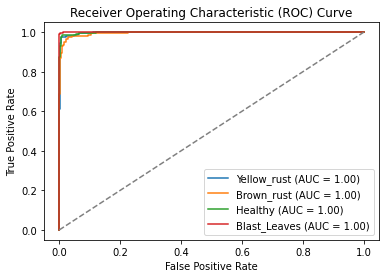

In [17]:
# 10 epochs train and test
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import Model

class ClassToken(Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value = w_init(shape=(1, 1, input_shape[-1]), dtype=tf.float32),
            trainable = True
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        hidden_dim = self.w.shape[-1]

        cls = tf.broadcast_to(self.w, [batch_size, 1, hidden_dim])
        cls = tf.cast(cls, dtype=inputs.dtype)
        return cls

def mlp(x, cf):
    x = Dense(cf["mlp_dim"], activation="gelu")(x)
    x = Dropout(cf["dropout_rate"])(x)
    x = Dense(cf["hidden_dim"])(x)
    x = Dropout(cf["dropout_rate"])(x)
    return x

def transformer_encoder(x, cf):
    skip_1 = x
    x = LayerNormalization()(x)
    x = MultiHeadAttention(
        num_heads=cf["num_heads"], key_dim=cf["hidden_dim"]
    )(x, x)
    x = Add()([x, skip_1])

    skip_2 = x
    x = LayerNormalization()(x)
    x = mlp(x, cf)
    x = Add()([x, skip_2])

    return x

def ViT(cf):
    """ Inputs """
    input_shape = (cf["num_patches"], cf["patch_size"]*cf["patch_size"]*cf["num_channels"])
    inputs = Input(input_shape)     ## (None, 256, 3072)

    """ Patch + Position Embeddings """
    patch_embed = Dense(cf["hidden_dim"])(inputs)   ## (None, 256, 768)

    positions = tf.range(start=0, limit=cf["num_patches"], delta=1)
    pos_embed = Embedding(input_dim=cf["num_patches"], output_dim=cf["hidden_dim"])(positions) ## (256, 768)
    embed = patch_embed + pos_embed ## (None, 256, 768)

    """ Adding Class Token """
    token = ClassToken()(embed)
    x = Concatenate(axis=1)([token, embed]) ## (None, 257, 768)

    for _ in range(cf["num_layers"]):
        x = transformer_encoder(x, cf)

    """ Classification Head """
    x = LayerNormalization()(x)     ## (None, 257, 768)
    x = x[:, 0, :]
    x = Dense(cf["num_classes"], activation="softmax")(x)

    model = Model(inputs, x)
    return model


if __name__ == "__main__":
    config = {}
    config["num_layers"] = 24
#     config["hidden_dim"] = 768
#     config["mlp_dim"] =3072
    config["num_heads"] = 12
    config["dropout_rate"] = 0.1
    config["num_patches"] = 256
    config["patch_size"] = 32
    config["num_channels"] = 3
    config["num_classes"] = 4

    config["hidden_dim"] = 256
    config["mlp_dim"] = 1024  

    model = ViT(config)
    model.summary()


# from google.colab import files
# uploaded = files.upload()
# from google.colab import drive
# drive.mount('/content/drive/')
import os
import cv2
import numpy as np
import tensorflow as tf
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold
from keras.metrics import AUC
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from patchify import patchify
# import tensorflow_hub as hub
# Assuming you have already imported or defined the ViT model
# ...
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
#from project import ViT
hp = {
    "image_size": 512,
    "num_channels": 3,
    "patch_size": 64,
    "num_classes": 4,
    "class_names": ["Yellow_rust","Brown_rust", "Healthy","Blast_Leaves"],
    "num_layers": 24,
    "hidden_dim": 256,
    "mlp_dim": 1024,
    "num_heads": 4,
    "dropout_rate": 0.1,
    "batch_size": 16,
    "lr": 1e-4,
    "num_epochs": 10
}
hp["num_patches"] = (hp["image_size"] ** 2) // (hp["patch_size"] ** 2)
hp["flat_patches_shape"] = (hp["num_patches"], hp["patch_size"] * hp["patch_size"] * hp["num_channels"])


def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)


def load_data(path, split=0.20):
    images = glob(os.path.join(path, "*", "*.jpg"))

    # Separate images by class
    images_class_BKL = [image for image in images if "Yellow_rust" in image]
    images_class_NV = [image for image in images if "Brown_rust" in image]
    images_class_MEL2 = [image for image in images if "Healthy" in image]
    images_class_BlastLeaves = [image for image in images if "Blast_Leaves" in image]

    # Oversample to 33,000 to match the largest class (BKL)
    target_size = len(images_class_BKL)
    #print(images_class_BKL)
    images_class_NV = np.random.choice(images_class_NV, size=target_size, replace=True).tolist()
    images_class_MEL2 = np.random.choice(images_class_MEL2, size=target_size, replace=True).tolist()
    images_class_BlastLeaves = np.random.choice(images_class_BlastLeaves, size=target_size, replace=True).tolist()
    # Concatenate lists again and shuffle
    images = shuffle(images_class_BKL + images_class_NV + images_class_MEL2+ images_class_BlastLeaves)

    split_size = int(len(images) * split)
    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    print(f"Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")

    return train_x, valid_x, test_x


def process_image_label(path):
    path = path.decode()
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (hp["image_size"], hp["image_size"]))
    image = image / 255.0

    patch_shape = (hp["patch_size"], hp["patch_size"], hp["num_channels"])
    patches = patchify(image, patch_shape, hp["patch_size"])
    patches = np.reshape(patches, hp["flat_patches_shape"])
    patches = patches.astype(np.float32)

    class_name = path.split("/")[-2]
    class_idx = hp["class_names"].index(class_name)
    class_idx = np.array(class_idx, dtype=np.int32)
    return patches, class_idx


def parse(path):
    patches, labels = tf.numpy_function(process_image_label, [path], [tf.float32, tf.int32])
    labels = tf.one_hot(labels, hp["num_classes"])

    patches.set_shape(hp["flat_patches_shape"])
    labels.set_shape(hp["num_classes"])

    return patches, labels


def tf_dataset(images, batch=32):
    ds = tf.data.Dataset.from_tensor_slices((images))
    ds = ds.map(parse).batch(batch).prefetch(8)
    return ds


def get_model():
    model = ViT(hp)
    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(hp["lr"], clipvalue=1.0),
        metrics=["acc", AUC(name='auc', multi_label=True)]
    )
    return model


if __name__ == "__main__":
    create_dir("files")
    dataset_path = '/home/ali/Music/PYTHON/WholeDataset'
    model_path = os.path.join("files", "model3.h5")
    csv_path = os.path.join("files", "log2.csv")
    train_x, valid_x, test_x = load_data(dataset_path)
    images = train_x + valid_x
    print(f"Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_no = 1

    for train, val in kfold.split(images):
        print(f'Training for fold {fold_no} ...')
        train_ds = tf_dataset(np.array(images)[train], batch=hp["batch_size"])
        valid_ds = tf_dataset(np.array(images)[val], batch=hp["batch_size"])
        model = get_model()
        callbacks = [
            ModelCheckpoint(f"files/modelN_fold{fold_no}.h5", monitor='val_loss', verbose=1, save_best_only=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-10, verbose=1),
            CSVLogger(f"files/log2_fold{fold_no}.csv"),
            EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False),
        ]
        print(2)
        model.fit(train_ds, epochs=hp["num_epochs"], validation_data=valid_ds, callbacks=callbacks)
        fold_no += 1
        print(3)

    # Evaluating on the test set
    print("Evaluating the test set...")
    test_ds = tf_dataset(test_x, batch=hp["batch_size"])
    all_preds = []
    custom_objects = {"ClassToken": ClassToken}
    for fold_no in range(1, 6):
        with tf.keras.utils.custom_object_scope(custom_objects):
            fold_model = tf.keras.models.load_model(f"files/modelN_fold{fold_no}.h5")
        y_pred_probs = fold_model.predict(test_ds)
        all_preds.append(y_pred_probs)

    avg_preds = np.mean(all_preds, axis=0)
    final_preds = np.argmax(avg_preds, axis=1)
    y_true = [hp["class_names"].index(img.split("/")[-2]) for img in test_x]
    print(classification_report(y_true, final_preds, target_names=hp["class_names"]))
    roc_aucs = []

    for i, class_name in enumerate(hp["class_names"]):
        auc_val = roc_auc_score((np.array(y_true) == i).astype(int), avg_preds[:, i])
        roc_aucs.append(auc_val)
        print(f"AUC-ROC ({class_name}): {auc_val:.4f}")

    for i, class_name in enumerate(hp["class_names"]):
        fpr, tpr, _ = roc_curve((np.array(y_true) == i).astype(int), avg_preds[:, i])
        plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_aucs[i]:.2f})")

    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

1157
1128
1500
1157
1157
1157
4628
Train: 2778 - Valid: 925 - Test: 925
Evaluating the test set...
58/58 [==============================] - 116s 2s/step
              precision    recall  f1-score   support

 Yellow_rust       0.95      0.97      0.96       214
  Brown_rust       0.97      0.94      0.95       233
     Healthy       0.98      0.97      0.97       245
Blast_Leaves       0.98      1.00      0.99       233

    accuracy                           0.97       925
   macro avg       0.97      0.97      0.97       925
weighted avg       0.97      0.97      0.97       925

AUC-ROC (Yellow_rust): 0.9985
AUC-ROC (Brown_rust): 0.9982
AUC-ROC (Healthy): 0.9984
AUC-ROC (Blast_Leaves): 0.9999


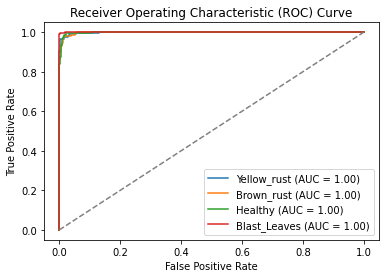

In [22]:
#test only
import os
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
#from project import ViT
from glob import glob
from sklearn.utils import shuffle
#from project import ClassToken
import cv2
from patchify import patchify
hp = {
    "image_size": 512,
    "num_channels": 3,
    "patch_size": 64,
    "num_classes": 4,
    "class_names": ["Yellow_rust","Brown_rust", "Healthy","Blast_Leaves"],
    "num_layers": 24,
    "hidden_dim": 768,
    "mlp_dim": 3072,
    "num_heads": 4,
    "dropout_rate": 0.1,
    "batch_size": 16,
    "lr": 1e-4,
    "num_epochs": 5
}
hp["num_patches"] = (hp["image_size"] ** 2) // (hp["patch_size"] ** 2)
hp["flat_patches_shape"] = (hp["num_patches"], hp["patch_size"] * hp["patch_size"] * hp["num_channels"])


def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)


def load_data(path, split=0.20):
    images = glob(os.path.join(path, "*", "*.jpg"))

    # Separate images by class
    images_class_BKL = [image for image in images if "Yellow_rust" in image]
    images_class_NV = [image for image in images if "Brown_rust" in image]
    images_class_MEL2 = [image for image in images if "Healthy" in image]
    images_class_BlastLeaves = [image for image in images if "Blast_Leaves" in image]
    print(len(images_class_BKL))
    print(len(images_class_NV))
    print(len(images_class_MEL2))
    # Oversample to 33,000 to match the largest class (BKL)
    target_size = len(images_class_BKL)
    #print(images_class_BKL)
    images_class_NV = np.random.choice(images_class_NV, size=target_size, replace=True).tolist()
    images_class_MEL2 = np.random.choice(images_class_MEL2, size=target_size, replace=True).tolist()
    images_class_BlastLeaves = np.random.choice(images_class_BlastLeaves, size=target_size, replace=True).tolist()
    # Concatenate lists again and shuffle
    images = shuffle(images_class_BKL + images_class_NV + images_class_MEL2+ images_class_BlastLeaves)

    print(len(images_class_BKL))
    print(len(images_class_NV))
    print(len(images_class_MEL2))
    print(len(images))
    split_size = int(len(images) * split)
    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    print(f"Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")

    return train_x, valid_x, test_x


def process_image_label(path):
    path = path.decode()
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (hp["image_size"], hp["image_size"]))
    image = image / 255.0

    patch_shape = (hp["patch_size"], hp["patch_size"], hp["num_channels"])
    patches = patchify(image, patch_shape, hp["patch_size"])
    patches = np.reshape(patches, hp["flat_patches_shape"])
    patches = patches.astype(np.float32)

    class_name = path.split("/")[-2]
    class_idx = hp["class_names"].index(class_name)
    class_idx = np.array(class_idx, dtype=np.int32)

    return patches, class_idx


def parse(path):
    patches, labels = tf.numpy_function(process_image_label, [path], [tf.float32, tf.int32])
    labels = tf.one_hot(labels, hp["num_classes"])

    patches.set_shape(hp["flat_patches_shape"])
    labels.set_shape(hp["num_classes"])

    return patches, labels


def tf_dataset(images, batch=32):
    ds = tf.data.Dataset.from_tensor_slices((images))
    ds = ds.map(parse).batch(batch).prefetch(8)
    return ds

# The main execution part
if __name__ == "__main__":
    dataset_path = '/home/ali/Music/PYTHON/WholeDataset'
    _, _, test_x = load_data(dataset_path)
    
    # Evaluating on the test set
    print("Evaluating the test set...")
    test_ds = tf_dataset(test_x, batch=hp["batch_size"])
    all_preds = []

    for fold_no in range(1, 6):
        fold_model = tf.keras.models.load_model(f"files/modelN_fold{fold_no}.h5", custom_objects={'ClassToken': ClassToken})
 #fold_model = tf.keras.models.load_model(f"files/modelN_fold{fold_no}.h5")
        y_pred_probs = fold_model.predict(test_ds)
        all_preds.append(y_pred_probs)

    avg_preds = np.mean(all_preds, axis=0)
    final_preds = np.argmax(avg_preds, axis=1)
    y_true = [hp["class_names"].index(img.split("/")[-2]) for img in test_x]
    print(classification_report(y_true, final_preds, target_names=hp["class_names"]))
    
    roc_aucs = []

    for i, class_name in enumerate(hp["class_names"]):
        auc_val = roc_auc_score((np.array(y_true) == i).astype(int), avg_preds[:, i])
        roc_aucs.append(auc_val)
        print(f"AUC-ROC ({class_name}): {auc_val:.4f}")

    for i, class_name in enumerate(hp["class_names"]):
        fpr, tpr, _ = roc_curve((np.array(y_true) == i).astype(int), avg_preds[:, i])
        plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_aucs[i]:.2f})")

    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [ ]:
# train only
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import Model

class ClassToken(Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value = w_init(shape=(1, 1, input_shape[-1]), dtype=tf.float32),
            trainable = True
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        hidden_dim = self.w.shape[-1]

        cls = tf.broadcast_to(self.w, [batch_size, 1, hidden_dim])
        cls = tf.cast(cls, dtype=inputs.dtype)
        return cls

def mlp(x, cf):
    x = Dense(cf["mlp_dim"], activation="gelu")(x)
    x = Dropout(cf["dropout_rate"])(x)
    x = Dense(cf["hidden_dim"])(x)
    x = Dropout(cf["dropout_rate"])(x)
    return x

def transformer_encoder(x, cf):
    skip_1 = x
    x = LayerNormalization()(x)
    x = MultiHeadAttention(
        num_heads=cf["num_heads"], key_dim=cf["hidden_dim"]
    )(x, x)
    x = Add()([x, skip_1])

    skip_2 = x
    x = LayerNormalization()(x)
    x = mlp(x, cf)
    x = Add()([x, skip_2])

    return x

def ViT(cf):
    """ Inputs """
    input_shape = (cf["num_patches"], cf["patch_size"]*cf["patch_size"]*cf["num_channels"])
    inputs = Input(input_shape)     ## (None, 256, 3072)

    """ Patch + Position Embeddings """
    patch_embed = Dense(cf["hidden_dim"])(inputs)   ## (None, 256, 768)

    positions = tf.range(start=0, limit=cf["num_patches"], delta=1)
    pos_embed = Embedding(input_dim=cf["num_patches"], output_dim=cf["hidden_dim"])(positions) ## (256, 768)
    embed = patch_embed + pos_embed ## (None, 256, 768)

    """ Adding Class Token """
    token = ClassToken()(embed)
    x = Concatenate(axis=1)([token, embed]) ## (None, 257, 768)

    for _ in range(cf["num_layers"]):
        x = transformer_encoder(x, cf)

    """ Classification Head """
    x = LayerNormalization()(x)     ## (None, 257, 768)
    x = x[:, 0, :]
    x = Dense(cf["num_classes"], activation="softmax")(x)

    model = Model(inputs, x)
    return model


if __name__ == "__main__":
    config = {}
    config["num_layers"] = 24
#     config["hidden_dim"] = 768
#     config["mlp_dim"] =3072
    config["num_heads"] = 12
    config["dropout_rate"] = 0.1
    config["num_patches"] = 256
    config["patch_size"] = 32
    config["num_channels"] = 3
    config["num_classes"] = 4

    config["hidden_dim"] = 512
    config["mlp_dim"] = 1024  

    model = ViT(config)
    model.summary()


# from google.colab import files
# uploaded = files.upload()
# from google.colab import drive
# drive.mount('/content/drive/')
import os
import cv2
import numpy as np
import tensorflow as tf
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold
from keras.metrics import AUC
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from patchify import patchify
# import tensorflow_hub as hub
# Assuming you have already imported or defined the ViT model
# ...
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
#from project import ViT
hp = {
    "image_size": 512,
    "num_channels": 3,
    "patch_size": 64,
    "num_classes": 4,
    "class_names": ["Yellow_rust","Brown_rust", "Healthy","Blast_Leaves"],
    "num_layers": 24,
    "hidden_dim": 512,
    "mlp_dim": 1024,
    "num_heads": 4,
    "dropout_rate": 0.1,
    "batch_size": 16,
    "lr": 1e-4,
    "num_epochs": 10
}
hp["num_patches"] = (hp["image_size"] ** 2) // (hp["patch_size"] ** 2)
hp["flat_patches_shape"] = (hp["num_patches"], hp["patch_size"] * hp["patch_size"] * hp["num_channels"])


def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)


def load_data(path, split=0.20):
    images = glob(os.path.join(path, "*", "*.jpg"))

    # Separate images by class
    images_class_BKL = [image for image in images if "Yellow_rust" in image]
    images_class_NV = [image for image in images if "Brown_rust" in image]
    images_class_MEL2 = [image for image in images if "Healthy" in image]
    images_class_BlastLeaves = [image for image in images if "Blast_Leaves" in image]

    # Oversample to 33,000 to match the largest class (BKL)
    target_size = len(images_class_BKL)
    #print(images_class_BKL)
    images_class_NV = np.random.choice(images_class_NV, size=target_size, replace=True).tolist()
    images_class_MEL2 = np.random.choice(images_class_MEL2, size=target_size, replace=True).tolist()
    images_class_BlastLeaves = np.random.choice(images_class_BlastLeaves, size=target_size, replace=True).tolist()
    # Concatenate lists again and shuffle
    images = shuffle(images_class_BKL + images_class_NV + images_class_MEL2+ images_class_BlastLeaves)

    split_size = int(len(images) * split)
    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    print(f"Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")

    return train_x, valid_x, test_x


def process_image_label(path):
    path = path.decode()
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (hp["image_size"], hp["image_size"]))
    image = image / 255.0

    patch_shape = (hp["patch_size"], hp["patch_size"], hp["num_channels"])
    patches = patchify(image, patch_shape, hp["patch_size"])
    patches = np.reshape(patches, hp["flat_patches_shape"])
    patches = patches.astype(np.float32)

    class_name = path.split("/")[-2]
    class_idx = hp["class_names"].index(class_name)
    class_idx = np.array(class_idx, dtype=np.int32)
    return patches, class_idx


def parse(path):
    patches, labels = tf.numpy_function(process_image_label, [path], [tf.float32, tf.int32])
    labels = tf.one_hot(labels, hp["num_classes"])

    patches.set_shape(hp["flat_patches_shape"])
    labels.set_shape(hp["num_classes"])

    return patches, labels


def tf_dataset(images, batch=32):
    ds = tf.data.Dataset.from_tensor_slices((images))
    ds = ds.map(parse).batch(batch).prefetch(8)
    return ds


def get_model():
    model = ViT(hp)
    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(hp["lr"], clipvalue=1.0),
        metrics=["acc", AUC(name='auc', multi_label=True)]
    )
    return model


if __name__ == "__main__":
    create_dir("files")
    dataset_path = '/home/ali/Music/PYTHON/WholeDataset'
    model_path = os.path.join("files", "model3.h5")
    csv_path = os.path.join("files", "log2.csv")
    train_x, valid_x, test_x = load_data(dataset_path)
    images = train_x + valid_x
    print(f"Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_no = 1

    for train, val in kfold.split(images):
        print(f'Training for fold {fold_no} ...')
        train_ds = tf_dataset(np.array(images)[train], batch=hp["batch_size"])
        valid_ds = tf_dataset(np.array(images)[val], batch=hp["batch_size"])
        model = get_model()
        callbacks = [
            ModelCheckpoint(f"files/modelN_fold{fold_no}.h5", monitor='val_loss', verbose=1, save_best_only=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-10, verbose=1),
            CSVLogger(f"files/log2_fold{fold_no}.csv"),
            EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False),
        ]
        print(2)
        model.fit(train_ds, epochs=hp["num_epochs"], validation_data=valid_ds, callbacks=callbacks)
        fold_no += 1
        print(3)

    # Evaluating on the test set
    print("Evaluating the test set...")
    test_ds = tf_dataset(test_x, batch=hp["batch_size"])
    all_preds = []
    custom_objects = {"ClassToken": ClassToken}
    for fold_no in range(1, 6):
        with tf.keras.utils.custom_object_scope(custom_objects):
            fold_model = tf.keras.models.load_model(f"files/modelN_fold{fold_no}.h5")
        y_pred_probs = fold_model.predict(test_ds)
        all_preds.append(y_pred_probs)

    avg_preds = np.mean(all_preds, axis=0)
    final_preds = np.argmax(avg_preds, axis=1)
    y_true = [hp["class_names"].index(img.split("/")[-2]) for img in test_x]
    print(classification_report(y_true, final_preds, target_names=hp["class_names"]))
    roc_aucs = []

    for i, class_name in enumerate(hp["class_names"]):
        auc_val = roc_auc_score((np.array(y_true) == i).astype(int), avg_preds[:, i])
        roc_aucs.append(auc_val)
        print(f"AUC-ROC ({class_name}): {auc_val:.4f}")

    for i, class_name in enumerate(hp["class_names"]):
        fpr, tpr, _ = roc_curve((np.array(y_true) == i).astype(int), avg_preds[:, i])
        plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_aucs[i]:.2f})")

    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

Model: "model_37"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_38 (InputLayer)       [(None, 256, 3072)]          0         []                            
                                                                                                  
 dense_1850 (Dense)          (None, 256, 512)             1573376   ['input_38[0][0]']            
                                                                                                  
 tf.__operators__.add_42 (T  (None, 256, 512)             0         ['dense_1850[0][0]']          
 FOpLambda)                                                                                       
                                                                                                  
 class_token_94 (ClassToken  (None, 1, 512)               512       ['tf.__operators__.add_

 layer_normalization_1818 (  (None, 257, 512)             1024      ['add_1780[0][0]']            
 LayerNormalization)                                                                              
                                                                                                  
 dense_1855 (Dense)          (None, 257, 1024)            525312    ['layer_normalization_1818[0][
                                                                    0]']                          
                                                                                                  
 dropout_3148 (Dropout)      (None, 257, 1024)            0         ['dense_1855[0][0]']          
                                                                                                  
 dense_1856 (Dense)          (None, 257, 512)             524800    ['dropout_3148[0][0]']        
                                                                                                  
 dropout_3

                                                                                                  
 dense_1861 (Dense)          (None, 257, 1024)            525312    ['layer_normalization_1824[0][
                                                                    0]']                          
                                                                                                  
 dropout_3154 (Dropout)      (None, 257, 1024)            0         ['dense_1861[0][0]']          
                                                                                                  
 dense_1862 (Dense)          (None, 257, 512)             524800    ['dropout_3154[0][0]']        
                                                                                                  
 dropout_3155 (Dropout)      (None, 257, 512)             0         ['dense_1862[0][0]']          
                                                                                                  
 add_1787 

                                                                    0]']                          
                                                                                                  
 dropout_3160 (Dropout)      (None, 257, 1024)            0         ['dense_1867[0][0]']          
                                                                                                  
 dense_1868 (Dense)          (None, 257, 512)             524800    ['dropout_3160[0][0]']        
                                                                                                  
 dropout_3161 (Dropout)      (None, 257, 512)             0         ['dense_1868[0][0]']          
                                                                                                  
 add_1793 (Add)              (None, 257, 512)             0         ['dropout_3161[0][0]',        
                                                                     'add_1792[0][0]']            
          

 dropout_3166 (Dropout)      (None, 257, 1024)            0         ['dense_1873[0][0]']          
                                                                                                  
 dense_1874 (Dense)          (None, 257, 512)             524800    ['dropout_3166[0][0]']        
                                                                                                  
 dropout_3167 (Dropout)      (None, 257, 512)             0         ['dense_1874[0][0]']          
                                                                                                  
 add_1799 (Add)              (None, 257, 512)             0         ['dropout_3167[0][0]',        
                                                                     'add_1798[0][0]']            
                                                                                                  
 layer_normalization_1837 (  (None, 257, 512)             1024      ['add_1799[0][0]']            
 LayerNorm

 dense_1880 (Dense)          (None, 257, 512)             524800    ['dropout_3172[0][0]']        
                                                                                                  
 dropout_3173 (Dropout)      (None, 257, 512)             0         ['dense_1880[0][0]']          
                                                                                                  
 add_1805 (Add)              (None, 257, 512)             0         ['dropout_3173[0][0]',        
                                                                     'add_1804[0][0]']            
                                                                                                  
 layer_normalization_1843 (  (None, 257, 512)             1024      ['add_1805[0][0]']            
 LayerNormalization)                                                                              
                                                                                                  
 multi_hea

 dropout_3179 (Dropout)      (None, 257, 512)             0         ['dense_1886[0][0]']          
                                                                                                  
 add_1811 (Add)              (None, 257, 512)             0         ['dropout_3179[0][0]',        
                                                                     'add_1810[0][0]']            
                                                                                                  
 layer_normalization_1849 (  (None, 257, 512)             1024      ['add_1811[0][0]']            
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_906 (  (None, 257, 512)             1260185   ['layer_normalization_1849[0][
 MultiHeadAttention)                                      6         0]',                          
          

 add_1817 (Add)              (None, 257, 512)             0         ['dropout_3185[0][0]',        
                                                                     'add_1816[0][0]']            
                                                                                                  
 layer_normalization_1855 (  (None, 257, 512)             1024      ['add_1817[0][0]']            
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_909 (  (None, 257, 512)             1260185   ['layer_normalization_1855[0][
 MultiHeadAttention)                                      6         0]',                          
                                                                     'layer_normalization_1855[0][
                                                                    0]']                          
          

                                                                                                  
 layer_normalization_1861 (  (None, 257, 512)             1024      ['add_1823[0][0]']            
 LayerNormalization)                                                                              
                                                                                                  
 tf.__operators__.getitem_4  (None, 512)                  0         ['layer_normalization_1861[0][
 2 (SlicingOpLambda)                                                0]']                          
                                                                                                  
 dense_1899 (Dense)          (None, 4)                    2052      ['tf.__operators__.getitem_42[
                                                                    0][0]']                       
                                                                                                  
Total para

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


186/186 [==============================] - 3247s 17s/step - loss: 1.4474 - acc: 0.4193 - auc: 0.6852 - val_loss: 1.3086 - val_acc: 0.4831 - val_auc: 0.8642 - lr: 1.0000e-04
Epoch 2/10
186/186 [==============================] - ETA: 0s - loss: 0.6127 - acc: 0.7404 - auc: 0.9206 
Epoch 2: val_loss improved from 1.30863 to 0.46330, saving model to files/modelN_fold1.h5
186/186 [==============================] - 3141s 17s/step - loss: 0.6127 - acc: 0.7404 - auc: 0.9206 - val_loss: 0.4633 - val_acc: 0.8111 - val_auc: 0.9709 - lr: 1.0000e-04
Epoch 3/10
186/186 [==============================] - ETA: 0s - loss: 0.3606 - acc: 0.8653 - auc: 0.9714 
Epoch 3: val_loss improved from 0.46330 to 0.25503, saving model to files/modelN_fold1.h5
186/186 [==============================] - 3176s 17s/step - loss: 0.3606 - acc: 0.8653 - auc: 0.9714 - val_loss: 0.2550 - val_acc: 0.9109 - val_auc: 0.9869 - lr: 1.0000e-04
Epoch 4/10
186/186 [==============================] - ETA: 0s - loss: 0.2527 - acc: 0.910

186/186 [==============================] - 3126s 17s/step - loss: 0.2829 - acc: 0.8916 - auc: 0.9820 - val_loss: 0.6126 - val_acc: 0.7625 - val_auc: 0.9762 - lr: 1.0000e-04
Epoch 5/10
186/186 [==============================] - ETA: 0s - loss: 0.2239 - acc: 0.9183 - auc: 0.9881 
Epoch 5: val_loss did not improve from 0.27830
186/186 [==============================] - 3202s 17s/step - loss: 0.2239 - acc: 0.9183 - auc: 0.9881 - val_loss: 0.4121 - val_acc: 0.8259 - val_auc: 0.9844 - lr: 1.0000e-04
Epoch 6/10
186/186 [==============================] - ETA: 0s - loss: 0.1679 - acc: 0.9399 - auc: 0.9927 
Epoch 6: val_loss did not improve from 0.27830
186/186 [==============================] - 3156s 17s/step - loss: 0.1679 - acc: 0.9399 - auc: 0.9927 - val_loss: 0.6995 - val_acc: 0.7220 - val_auc: 0.9834 - lr: 1.0000e-04
Epoch 7/10
186/186 [==============================] - ETA: 0s - loss: 0.1932 - acc: 0.9311 - auc: 0.9909 
Epoch 7: val_loss did not improve from 0.27830
186/186 [=============

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 3072)]          0         []                            
                                                                                                  
 dense (Dense)               (None, 256, 512)             1573376   ['input_1[0][0]']             
                                                                                                  
 tf.__operators__.add (TFOp  (None, 256, 512)             0         ['dense[0][0]']               
 Lambda)                                                                                          
                                                                                                  
 class_token (ClassToken)    (None, 1, 512)               512       ['tf.__operators__.add[0][

                                                                                                  
 dense_6 (Dense)             (None, 257, 512)             524800    ['dropout_4[0][0]']           
                                                                                                  
 dropout_5 (Dropout)         (None, 257, 512)             0         ['dense_6[0][0]']             
                                                                                                  
 add_5 (Add)                 (None, 257, 512)             0         ['dropout_5[0][0]',           
                                                                     'add_4[0][0]']               
                                                                                                  
 layer_normalization_6 (Lay  (None, 257, 512)             1024      ['add_5[0][0]']               
 erNormalization)                                                                                 
          

                                                                                                  
 add_11 (Add)                (None, 257, 512)             0         ['dropout_11[0][0]',          
                                                                     'add_10[0][0]']              
                                                                                                  
 layer_normalization_12 (La  (None, 257, 512)             1024      ['add_11[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 multi_head_attention_6 (Mu  (None, 257, 512)             1260185   ['layer_normalization_12[0][0]
 ltiHeadAttention)                                        6         ',                            
                                                                     'layer_normalization_12[0][0]
          

                                                                     'add_16[0][0]']              
                                                                                                  
 layer_normalization_18 (La  (None, 257, 512)             1024      ['add_17[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 multi_head_attention_9 (Mu  (None, 257, 512)             1260185   ['layer_normalization_18[0][0]
 ltiHeadAttention)                                        6         ',                            
                                                                     'layer_normalization_18[0][0]
                                                                    ']                            
                                                                                                  
 add_18 (A

 layer_normalization_24 (La  (None, 257, 512)             1024      ['add_23[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 multi_head_attention_12 (M  (None, 257, 512)             1260185   ['layer_normalization_24[0][0]
 ultiHeadAttention)                                       6         ',                            
                                                                     'layer_normalization_24[0][0]
                                                                    ']                            
                                                                                                  
 add_24 (Add)                (None, 257, 512)             0         ['multi_head_attention_12[0][0
                                                                    ]',                           
          

                                                                                                  
 multi_head_attention_15 (M  (None, 257, 512)             1260185   ['layer_normalization_30[0][0]
 ultiHeadAttention)                                       6         ',                            
                                                                     'layer_normalization_30[0][0]
                                                                    ']                            
                                                                                                  
 add_30 (Add)                (None, 257, 512)             0         ['multi_head_attention_15[0][0
                                                                    ]',                           
                                                                     'add_29[0][0]']              
                                                                                                  
 layer_nor

 ultiHeadAttention)                                       6         ',                            
                                                                     'layer_normalization_36[0][0]
                                                                    ']                            
                                                                                                  
 add_36 (Add)                (None, 257, 512)             0         ['multi_head_attention_18[0][0
                                                                    ]',                           
                                                                     'add_35[0][0]']              
                                                                                                  
 layer_normalization_37 (La  (None, 257, 512)             1024      ['add_36[0][0]']              
 yerNormalization)                                                                                
          

                                                                    ']                            
                                                                                                  
 add_42 (Add)                (None, 257, 512)             0         ['multi_head_attention_21[0][0
                                                                    ]',                           
                                                                     'add_41[0][0]']              
                                                                                                  
 layer_normalization_43 (La  (None, 257, 512)             1024      ['add_42[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 dense_43 (Dense)            (None, 257, 1024)            525312    ['layer_normalization_43[0][0]
          

                                                                                                  
Total params: 329273348 (1.23 GB)
Trainable params: 329273348 (1.23 GB)
Non-trainable params: 0 (0.00 Byte)
__________________________________________________________________________________________________
Train: 2778 - Valid: 925 - Test: 925
Train: 2778 - Valid: 925 - Test: 925
Evaluating the test set...
58/58 [==============================] - 316s 5s/step
              precision    recall  f1-score   support

 Yellow_rust       0.95      0.84      0.89       237
  Brown_rust       0.85      0.94      0.89       235
     Healthy       0.95      0.95      0.95       241
Blast_Leaves       0.99      1.00      1.00       212

    accuracy                           0.93       925
   macro avg       0.93      0.93      0.93       925
weighted avg       0.93      0.93      0.93       925

AUC-ROC (Yellow_rust): 0.9925
AUC-ROC (Brown_rust): 0.9879
AUC-ROC (Healthy): 0.9974
AUC-ROC (Blast_Leav

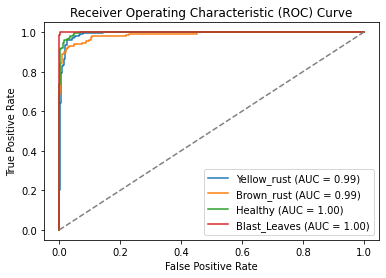

In [2]:
#test only
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import Model

class ClassToken(Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value = w_init(shape=(1, 1, input_shape[-1]), dtype=tf.float32),
            trainable = True
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        hidden_dim = self.w.shape[-1]

        cls = tf.broadcast_to(self.w, [batch_size, 1, hidden_dim])
        cls = tf.cast(cls, dtype=inputs.dtype)
        return cls

def mlp(x, cf):
    x = Dense(cf["mlp_dim"], activation="gelu")(x)
    x = Dropout(cf["dropout_rate"])(x)
    x = Dense(cf["hidden_dim"])(x)
    x = Dropout(cf["dropout_rate"])(x)
    return x

def transformer_encoder(x, cf):
    skip_1 = x
    x = LayerNormalization()(x)
    x = MultiHeadAttention(
        num_heads=cf["num_heads"], key_dim=cf["hidden_dim"]
    )(x, x)
    x = Add()([x, skip_1])

    skip_2 = x
    x = LayerNormalization()(x)
    x = mlp(x, cf)
    x = Add()([x, skip_2])

    return x

def ViT(cf):
    """ Inputs """
    input_shape = (cf["num_patches"], cf["patch_size"]*cf["patch_size"]*cf["num_channels"])
    inputs = Input(input_shape)     ## (None, 256, 3072)

    """ Patch + Position Embeddings """
    patch_embed = Dense(cf["hidden_dim"])(inputs)   ## (None, 256, 768)

    positions = tf.range(start=0, limit=cf["num_patches"], delta=1)
    pos_embed = Embedding(input_dim=cf["num_patches"], output_dim=cf["hidden_dim"])(positions) ## (256, 768)
    embed = patch_embed + pos_embed ## (None, 256, 768)

    """ Adding Class Token """
    token = ClassToken()(embed)
    x = Concatenate(axis=1)([token, embed]) ## (None, 257, 768)

    for _ in range(cf["num_layers"]):
        x = transformer_encoder(x, cf)

    """ Classification Head """
    x = LayerNormalization()(x)     ## (None, 257, 768)
    x = x[:, 0, :]
    x = Dense(cf["num_classes"], activation="softmax")(x)

    model = Model(inputs, x)
    return model


if __name__ == "__main__":
    config = {}
    config["num_layers"] = 24
#     config["hidden_dim"] = 768
#     config["mlp_dim"] =3072
    config["num_heads"] = 12
    config["dropout_rate"] = 0.1
    config["num_patches"] = 256
    config["patch_size"] = 32
    config["num_channels"] = 3
    config["num_classes"] = 4

    config["hidden_dim"] = 512
    config["mlp_dim"] = 1024  

    model = ViT(config)
    model.summary()


# from google.colab import files
# uploaded = files.upload()
# from google.colab import drive
# drive.mount('/content/drive/')
import os
import cv2
import numpy as np
import tensorflow as tf
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold
from keras.metrics import AUC
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from patchify import patchify
# import tensorflow_hub as hub
# Assuming you have already imported or defined the ViT model
# ...
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
#from project import ViT
hp = {
    "image_size": 512,
    "num_channels": 3,
    "patch_size": 64,
    "num_classes": 4,
    "class_names": ["Yellow_rust","Brown_rust", "Healthy","Blast_Leaves"],
    "num_layers": 24,
    "hidden_dim": 512,
    "mlp_dim": 1024,
    "num_heads": 4,
    "dropout_rate": 0.1,
    "batch_size": 16,
    "lr": 1e-4,
    "num_epochs": 10
}
hp["num_patches"] = (hp["image_size"] ** 2) // (hp["patch_size"] ** 2)
hp["flat_patches_shape"] = (hp["num_patches"], hp["patch_size"] * hp["patch_size"] * hp["num_channels"])


def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)


def load_data(path, split=0.20):
    images = glob(os.path.join(path, "*", "*.jpg"))

    # Separate images by class
    images_class_BKL = [image for image in images if "Yellow_rust" in image]
    images_class_NV = [image for image in images if "Brown_rust" in image]
    images_class_MEL2 = [image for image in images if "Healthy" in image]
    images_class_BlastLeaves = [image for image in images if "Blast_Leaves" in image]

    # Oversample to 33,000 to match the largest class (BKL)
    target_size = len(images_class_BKL)
    #print(images_class_BKL)
    images_class_NV = np.random.choice(images_class_NV, size=target_size, replace=True).tolist()
    images_class_MEL2 = np.random.choice(images_class_MEL2, size=target_size, replace=True).tolist()
    images_class_BlastLeaves = np.random.choice(images_class_BlastLeaves, size=target_size, replace=True).tolist()
    # Concatenate lists again and shuffle
    images = shuffle(images_class_BKL + images_class_NV + images_class_MEL2+ images_class_BlastLeaves)

    split_size = int(len(images) * split)
    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    print(f"Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")

    return train_x, valid_x, test_x


def process_image_label(path):
    path = path.decode()
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (hp["image_size"], hp["image_size"]))
    image = image / 255.0

    patch_shape = (hp["patch_size"], hp["patch_size"], hp["num_channels"])
    patches = patchify(image, patch_shape, hp["patch_size"])
    patches = np.reshape(patches, hp["flat_patches_shape"])
    patches = patches.astype(np.float32)

    class_name = path.split("/")[-2]
    class_idx = hp["class_names"].index(class_name)
    class_idx = np.array(class_idx, dtype=np.int32)
    return patches, class_idx


def parse(path):
    patches, labels = tf.numpy_function(process_image_label, [path], [tf.float32, tf.int32])
    labels = tf.one_hot(labels, hp["num_classes"])

    patches.set_shape(hp["flat_patches_shape"])
    labels.set_shape(hp["num_classes"])

    return patches, labels


def tf_dataset(images, batch=32):
    ds = tf.data.Dataset.from_tensor_slices((images))
    ds = ds.map(parse).batch(batch).prefetch(8)
    return ds


def get_model():
    model = ViT(hp)
    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(hp["lr"], clipvalue=1.0),
        metrics=["acc", AUC(name='auc', multi_label=True)]
    )
    return model


if __name__ == "__main__":
    create_dir("files")
    dataset_path = '/home/ali/Music/PYTHON/WholeDataset'
    model_path = os.path.join("files", "model3.h5")
    csv_path = os.path.join("files", "log2.csv")
    train_x, valid_x, test_x = load_data(dataset_path)
    images = train_x + valid_x
    print(f"Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_no = 1

#     for train, val in kfold.split(images):
#         print(f'Training for fold {fold_no} ...')
#         train_ds = tf_dataset(np.array(images)[train], batch=hp["batch_size"])
#         valid_ds = tf_dataset(np.array(images)[val], batch=hp["batch_size"])
#         model = get_model()
#         callbacks = [
#             ModelCheckpoint(f"files/modelN_fold{fold_no}.h5", monitor='val_loss', verbose=1, save_best_only=True),
#             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-10, verbose=1),
#             CSVLogger(f"files/log2_fold{fold_no}.csv"),
#             EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False),
#         ]
#         print(2)
#         model.fit(train_ds, epochs=hp["num_epochs"], validation_data=valid_ds, callbacks=callbacks)
#         fold_no += 1
#         print(3)

    # Evaluating on the test set
    print("Evaluating the test set...")
    test_ds = tf_dataset(test_x, batch=hp["batch_size"])
    all_preds = []
    custom_objects = {"ClassToken": ClassToken}
    for fold_no in range(1, 6):
        with tf.keras.utils.custom_object_scope(custom_objects):
            fold_model = tf.keras.models.load_model(f"files/modelN_fold{fold_no}.h5")
        y_pred_probs = fold_model.predict(test_ds)
        all_preds.append(y_pred_probs)

    avg_preds = np.mean(all_preds, axis=0)
    final_preds = np.argmax(avg_preds, axis=1)
    y_true = [hp["class_names"].index(img.split("/")[-2]) for img in test_x]
    print(classification_report(y_true, final_preds, target_names=hp["class_names"]))
    roc_aucs = []

    for i, class_name in enumerate(hp["class_names"]):
        auc_val = roc_auc_score((np.array(y_true) == i).astype(int), avg_preds[:, i])
        roc_aucs.append(auc_val)
        print(f"AUC-ROC ({class_name}): {auc_val:.4f}")

    for i, class_name in enumerate(hp["class_names"]):
        fpr, tpr, _ = roc_curve((np.array(y_true) == i).astype(int), avg_preds[:, i])
        plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_aucs[i]:.2f})")

    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()